In [1]:
import logging
import pathlib
import os
import tempfile
import subprocess

import pandas as pd
import seaborn
import pydub
from tqdm.notebook import tqdm
from google.cloud import storage
from google.cloud import speech


tqdm.pandas()
logger = logging.getLogger(__name__)

# Constants

In [2]:
frame_rate = 16000
max_chunk_duration_seconds = 10
target_normalization_db = -23

# Convert original file to wav

In [3]:
lines = pd.read_csv("../data/original_files.csv")
lines["from"] = lines["from"].apply(pd.Timedelta)
lines["to"] = lines["to"].apply(pd.Timedelta)
lines

,original_audio,from,to
0,/hd4tb/archivio_barbero/7_La_Prima_Guerra_Mond...,0 days 00:01:22,0 days 01:09:48
1,/hd4tb/archivio_barbero/8_Come_scoppiano_le_gu...,0 days 00:00:00,0 days 01:07:37
2,/hd4tb/archivio_barbero/9_La_Guerra_delle_Falk...,0 days 00:00:55,0 days 01:01:36


In [4]:
def convert(row):
    input_file = pathlib.Path(row["original_audio"])
    folder = input_file.parent
    name = input_file.stem
    output_name = folder / "wav" / f"{name}.wav"
    sound = pydub.AudioSegment.from_mp3(input_file)
    sound = sound.set_channels(1)  # save to mono
    # cut the section between from and to
    beginning = 1000 * int(row["from"].total_seconds())
    end = 1000 * int(row["to"].total_seconds())
    sound = sound[beginning:end]
    sound.set_frame_rate(frame_rate)
    sound.export(output_name, format="wav")
    logger.debug("converted %s to %s", input_file, output_name)
    return output_name

In [5]:
lines["wav"] = lines.progress_apply(convert, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Normalize

In [6]:
def normalize(row):
    input_file = pathlib.Path(row["wav"])
    folder = input_file.parent
    name = input_file.stem
    output_name = folder / "normalized_wav" / f"{name}.wav"
    # stupid business with using a non-ext4 filesystem
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_out_name = pathlib.Path(tmpdirname) / output_name.name
        command = f"ffmpeg-normalize -f --normalization-type rms --target-level {target_normalization_db} {row['wav']} -o {temp_out_name}"
        subprocess.check_call(command, shell=True)
        command = f"mv {temp_out_name} {output_name}"
        subprocess.check_call(command, shell=True)
    return output_name

In [11]:
lines["normalized_wav"] = lines.progress_apply(normalize, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014.wav': Operation not permitted
mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2.wav': Operation not permitted
mv: preserving times for '/hd4tb/archivio_barbero/wav/normalized_wav/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014.wav': Operation not permitted


# Split wav file into chunks

In [12]:
def split_on_silence(row, min_silence_len, silence_thresh):
    input_file = row["normalized_wav"]
    sound = pydub.AudioSegment.from_file(input_file, format="wav")
    chunks = pydub.silence.split_on_silence(
        sound,
        min_silence_len=min_silence_len,
        silence_thresh=silence_thresh,
        keep_silence=True,
    )
    durations = pd.DataFrame(
        {
            "chunk": chunks,
            "duration": [chunk.duration_seconds for chunk in chunks],
        }
    )
    durations["wav"] = input_file
    return durations

In [13]:
chunks = lines.progress_apply(split_on_silence, axis=1, min_silence_len=1400, silence_thresh=-29)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
single_chunks = pd.concat(chunks.tolist()).reset_index()

<AxesSubplot: ylabel='duration'>

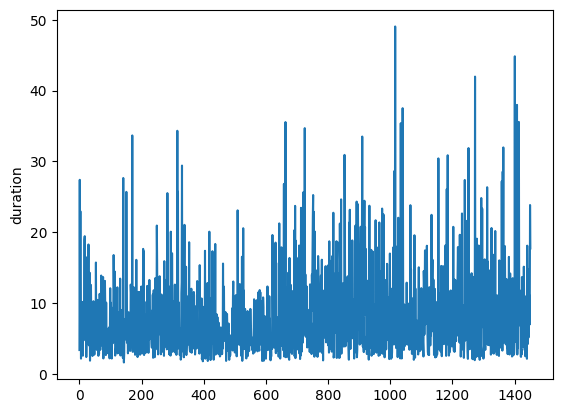

In [15]:
seaborn.lineplot(x=single_chunks.index, y=single_chunks.duration)

<AxesSubplot: xlabel='duration', ylabel='Count'>

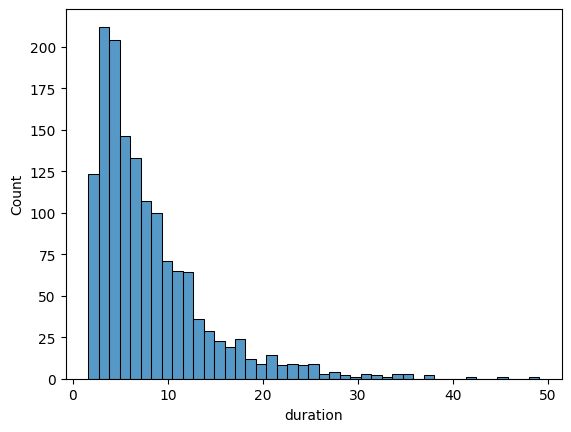

In [16]:
seaborn.histplot(single_chunks.duration)

In [19]:
single_chunks.head()["chunk"].iloc[0]

In [ ]:
def save_chunk(row):
    original_audio = pathlib.Path(row["flac"])
    folder = original_audio.parent.parent / "splits" / original_audio.stem
    folder.mkdir(exist_ok=True, parents=True)
    output_name = folder / f"{row['index']:03}.flac"
    row["chunk"].export(output_name, format="flac")
    return output_name

In [ ]:
single_chunks["path"] = single_chunks.progress_apply(save_chunk, axis=1)

In [ ]:
single_chunks["flac"].value_counts()

In [ ]:
single_chunks2 = single_chunks[single_chunks["flac"].apply(str).str.contains("seconda")]

In [ ]:
single_chunks2["path"] = single_chunks2.progress_apply(save_chunk, axis=1)

In [ ]:
single_chunks2

# Upload Files to GCS

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../secrets/barbero-translations-0ea9c0d3c73f.json"
client = storage.Client()
bucket = client.bucket("barbero-translations")

In [ ]:
def upload(row, bucket):
    blob_name = f"splits/{pathlib.Path(row['flac']).stem}/{pathlib.Path(row['path']).name}"
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(row["path"])
    return f"gs://{bucket.name}/{blob_name}"

In [ ]:
single_chunks["gcs_uri"] = single_chunks.progress_apply(upload, axis=1, bucket=bucket)

In [ ]:
single_chunks2["gcs_uri"] = single_chunks2.progress_apply(upload, axis=1, bucket=bucket)

# Speech to Text

In [ ]:
speech_client = speech.SpeechClient()

In [ ]:
def speech_to_text(row, client):
    audio = speech.RecognitionAudio(uri=row["gcs_uri"])
    transcription_gcs_uri = row["gcs_uri"].replace("splits", "transcripts").replace(".flac", ".json")
    config = speech.RecognitionConfig(
        language_code="it-IT",
        profanity_filter=False,
        enable_automatic_punctuation=True,
        model="latest_short",
    )
    output_config = speech.TranscriptOutputConfig(
        gcs_uri=transcription_gcs_uri,
    )
    request = speech.LongRunningRecognizeRequest(config=config, audio=audio, output_config=output_config)
    operation = client.long_running_recognize(request=request)
    response = operation.result()
    row["transcription_gcs_uri"] = transcription_gcs_uri
    row["response"] = response
    return row

In [ ]:
transcribed = single_chunks.progress_apply(speech_to_text, axis=1, client=speech_client)

In [ ]:
transcribed2 = single_chunks2.progress_apply(speech_to_text, axis=1, client=speech_client)

In [ ]:
transcribed.head(1).transpose()

In [ ]:
transcribed = pd.concat((transcribed[~transcribed["flac"].apply(str).str.contains("seconda")], transcribed2)).sort_values(["flac", "index"]).reset_index(drop=True)

# Extract the speech to text results

In [ ]:
def extract_result(row):
    row["transcription"] = " ".join(x.alternatives[0].transcript for x in row["response"].results)
    row["billed_time"] = row["response"].total_billed_time
    return row

In [ ]:
extracted = transcribed.progress_apply(extract_result, axis=1)

In [ ]:
extracted[["transcription", "billed_time", "duration"]]

Total billed transcription time:

In [ ]:
extracted["billed_time"].sum()

Total audio time:

In [ ]:
pd.to_timedelta(extracted["duration"].sum(), unit="s")

# Manually clean the transcription

In [ ]:
extracted["edited_transcription"] = extracted["transcription"]
extracted["barbero"] = 1
extracted[["barbero", "edited_transcription", "path"]].to_csv("../data/extracted2.csv")

In [ ]:
cleaned = pd.read_csv("../data/extracted.csv").rename(columns={"Unnamed: 0": "index"}).astype({"index": "Int64"}).sort_values("index")

In [ ]:
cleaned

In [ ]:
extracted["path"] = extracted["path"].apply(str)
merged = pd.merge(
    extracted.drop(columns=["edited_transcription", "barbero", "index"]),
    cleaned,
    on=["path"],
    how="left",
)

In [ ]:
merged

In [ ]:
merged.to_pickle("../data/merged.pkl.gz")

In [ ]:
def write_wavs(row):
    path = pathlib.Path(row['path'])
    folder = pathlib.Path(f"/ssd500gb/archivio_barbero/split_wav/{path.parent.name}")
    folder.mkdir(exist_ok=True, parents=True)
    output_name = f"{folder}/{path.stem}.wav"
    chunk = row["chunk"]
    chunk.set_frame_rate(16000).export(output_name, format="wav")
    return output_name

In [ ]:
merged["audio_file"] = merged.progress_apply(write_wavs, axis=1)

In [ ]:
final = merged[merged["barbero"].astype(bool)][["audio_file", "edited_transcription"]].rename(columns={"edited_transcription": "text"})
final["audio_file"] = final["audio_file"].apply(lambda x: pathlib.Path(x).relative_to(pathlib.Path(x).parent.parent))

# Transcribe numbers

In [ ]:
import re
from num2words import num2words


def transcribe_numbers(row):
    text = row["text"]
    numbers = re.findall("[0-9]+", text)
    if numbers:
        for number in numbers:
            transcribed = num2words(int(number), lang="it")
            text = text.replace(number, transcribed)
    return text

In [ ]:
final["text"] = final.progress_apply(transcribe_numbers, axis=1)

In [ ]:
final.to_csv("../data/audio_metadata.csv", sep="|", index=False)